# Домашняя работа по теме «Элементарные методы анализа временных рядов»

1. Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.

2. Приблизьте оба варианта моделями из класса MA.

3. Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

## 1. Нестационарный временной ряд - international-airline-passengers

In [4]:
series = pd.read_csv("international-airline-passengers.csv")['Count']

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


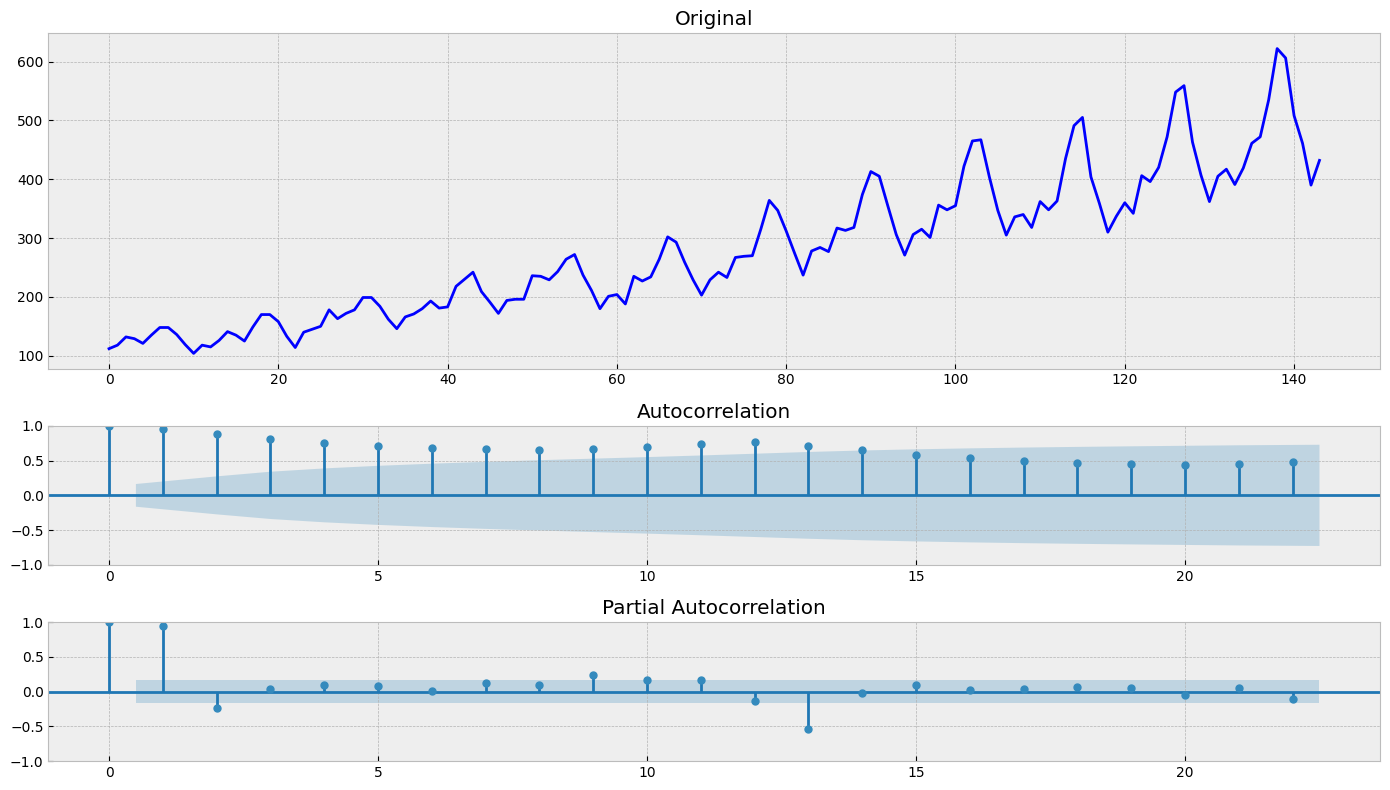

In [5]:
tsplot(series)

Так как, судя по графику, во временном ряде присутствует тренд и сезонность, для приближения лучше использовать модель Хольта-Винтерса, учитывающую три компоненты.

In [6]:
def initial_trend(series, season_len):
  sum = 0
  for i in range(season_len):
    sum += float(series[i+season_len] - series[i]) / season_len
  return sum / season_len

In [7]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [8]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [9]:
def plot_tema(alpha, beta, gamma, ser=series, ser_to_plot=series, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}, rmse={}".format(alpha, beta, gamma, mean_squared_error(series, tema)))
        plt.legend()

In [10]:
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

In [11]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3)
    errors = []

    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [12]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

9600.769178206918------------
9600.764845241367------------
9600.769178206918------------
9600.768819075922------------
9600.758118275875------------
9600.75378531835------------
9600.758118271551------------
9600.757759145514------------
5760.869289127314------------
5760.867564502936------------
5760.868130937089------------
5760.869136494514------------
2227.399882865802------------
2227.3997496318557------------
2227.3988178855866------------
2227.3998671040513------------
2227.399129856389------------
2227.3989966224576------------
2227.3980648767233------------
2227.3991140946587------------
1276.6758589504473------------
1276.675785127795------------
1276.6754656879068------------
1276.675854674144------------
596.6453453695189------------
596.6453254772813------------
596.6453265843231------------
596.6453446888219------------
596.6452737025371------------
596.6452538103177------------
596.6452549173529------------
596.6452730218443------------
547.4276348562853------------
547

In [13]:
alpha_opt, beta_opt, gamma_opt = opt.x

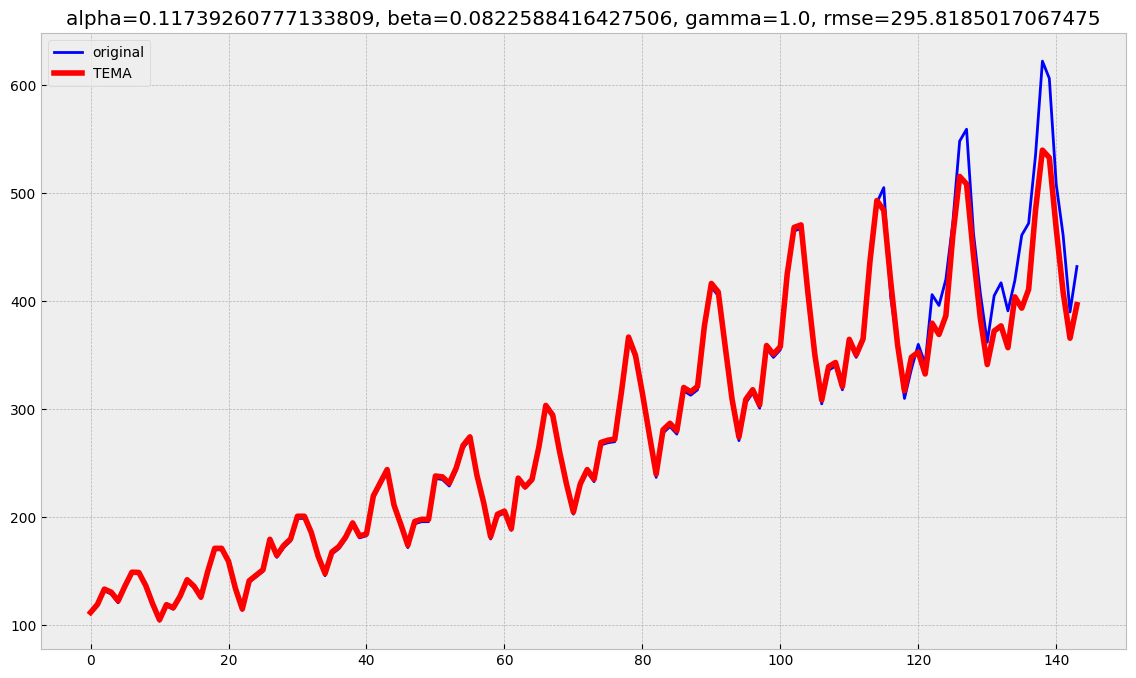

In [14]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(test))

## 2. Стационарный временной ряд - mean-monthly-air-temperature-deg

In [15]:
series_2 = pd.read_csv("mean-monthly-air-temperature-deg.csv")['Deg']

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


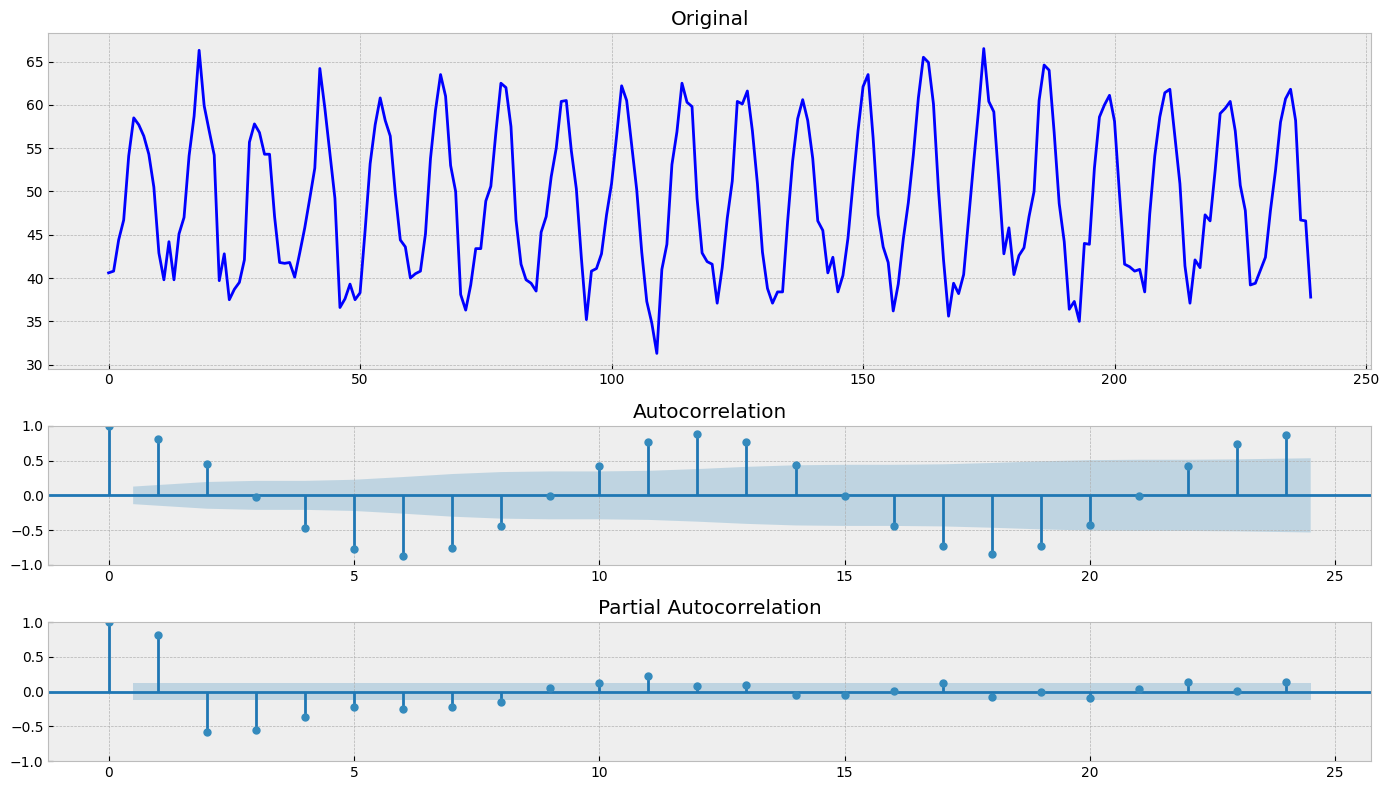

In [16]:
tsplot(series_2)

Так как выявить наличие тренда или сезонности по графику сложно, нет видимых выбросов, которые могли бы повлиять на результат, для приближения можно использовать взвешенное скользящее среднее.

In [17]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [18]:
wma_fib = weighted_moving_average(series_2, 7, [1,1,2,3,5,8,13])
wma_seq = weighted_moving_average(series_2, 7, [1,2,3,4,5,6,7])
wma_pow = weighted_moving_average(series_2, 7, [1,2,4,8,16,32,64])

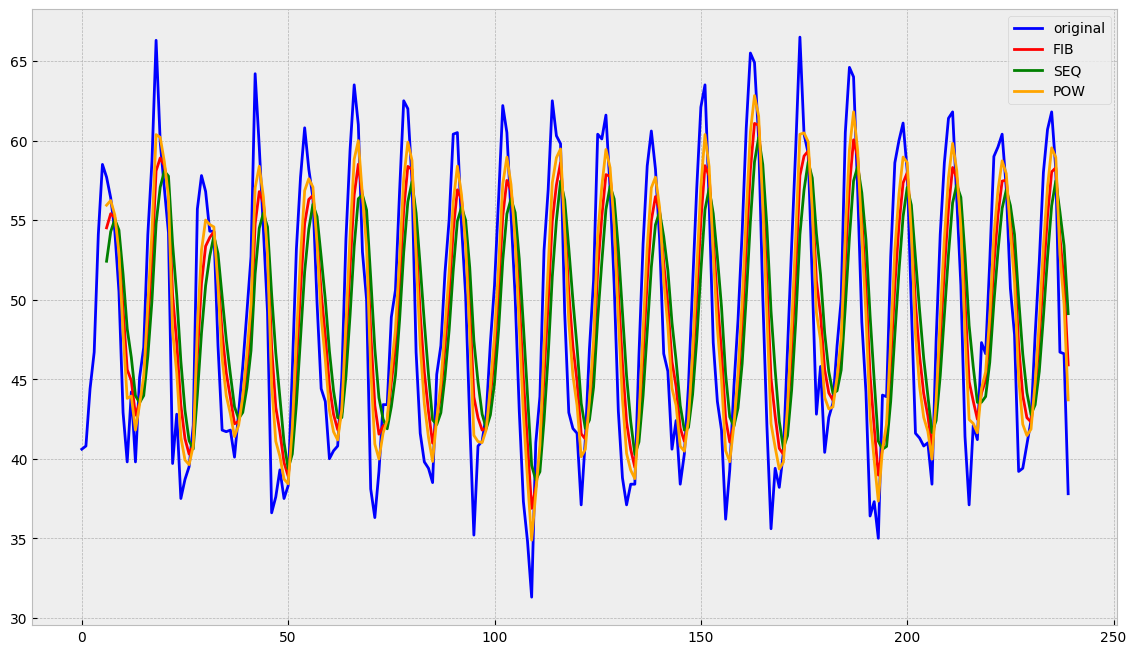

In [19]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_2, color='blue',label='original')

    plt.plot(wma_fib, color='red', linewidth='2', label='FIB')
    plt.plot(wma_seq, color='green', linewidth='2', label='SEQ')
    plt.plot(wma_pow, color='orange', linewidth='2', label='POW')
    plt.legend()

In [20]:
print(mean_squared_error(series_2[6:], wma_fib[6:]))
print(mean_squared_error(series_2[6:], wma_seq[6:]))
print(mean_squared_error(series_2[6:], wma_pow[6:]))

25.241511344996198
49.71973187031223
13.638293149834166


Из выбранных весов наилучшее приближение показывает wma_pow

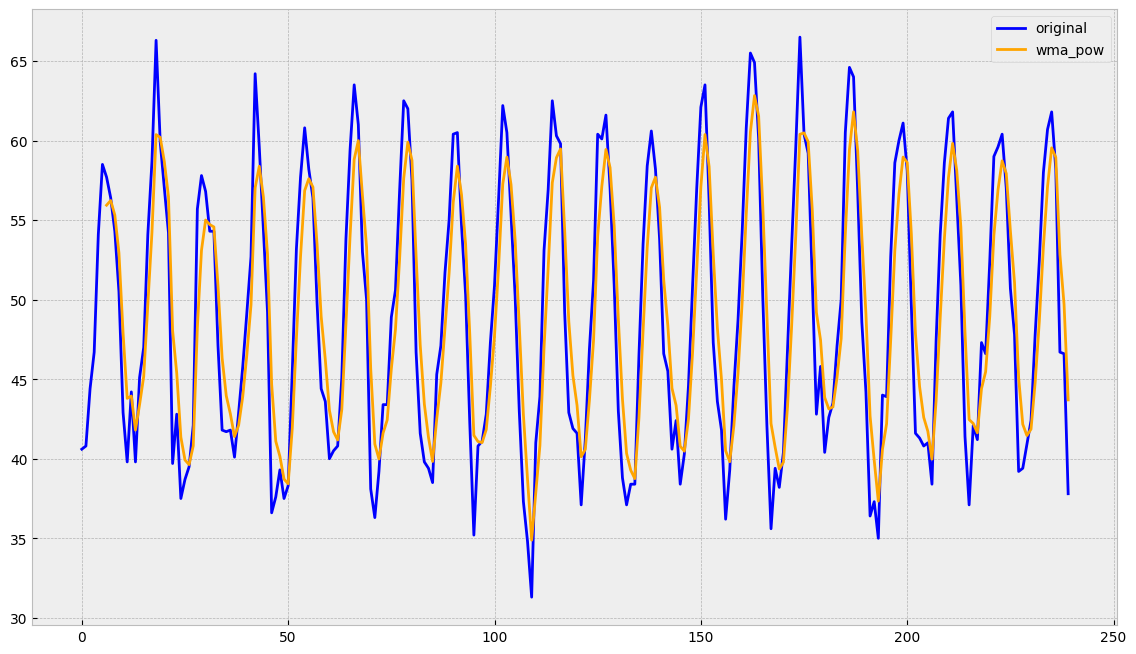

In [22]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_2, color='blue',label='original')
    plt.plot(wma_pow, color='orange', linewidth='2', label='wma_pow')
    plt.legend()